In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
while 'notebooks' in os.getcwd():
    os.chdir("..")

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
from src.attention_rollout import AttentionRollout
from src.gradient_rollout import AttentionGradRollout
from src.influence import Influence
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

import seaborn as sns
import numpy as np
import pandas as pd
import wordcloud
from src.text_utils import remove_stopwords, remove_punctuation, get_word_frequencies, lemmatize_text
from copy import deepcopy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'no-latex'])
from src.perturbation import perturb_text

In [16]:
device = 'cuda'

# Attention Rollout

## AG News

In [17]:
train_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'train')\
    .train_test_split(test_size=1000, train_size=2000, seed=1)

test_dataset = load_dataset("SetFit/ag_news", cache_dir='/Data', split = 'test')

In [18]:
n_classes = len(np.bincount(train_dataset['train']['label']))

In [19]:
label_names = {
    0 : "World",
    1 : "Sports",
    2 : "Business",
    3 : "Sci/Tech"
}

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    "peulsilva/bert-ag_news", 
    attn_implementation = 'eager', 
    num_labels = n_classes,
    cache_dir = '/Data'
)\
    .to(device)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [21]:
batch_size = 1
train_dataloader = DataLoader(train_dataset['train'], batch_size=batch_size)
val_dataloader = DataLoader(train_dataset['test'], batch_size=batch_size)

In [19]:
metric = AttentionRollout(model, attention_layer_name='attention')

In [20]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        out, attn_matrix = metric(**tokens.to(device), output_attentions = True)

        new_input = perturb_text(tokens, attn_matrix.squeeze(), k, tokenizer)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} best tokens. Accuracy = {acc}")

100%|██████████| 1000/1000 [00:17<00:00, 55.98it/s]


Removed 0.0 best tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:18<00:00, 53.89it/s]


Removed 0.1 best tokens. Accuracy = 0.8970000147819519


100%|██████████| 1000/1000 [00:18<00:00, 54.27it/s]


Removed 0.2 best tokens. Accuracy = 0.8320000171661377


100%|██████████| 1000/1000 [00:18<00:00, 54.29it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.7850000262260437


100%|██████████| 1000/1000 [00:18<00:00, 53.87it/s]


Removed 0.4 best tokens. Accuracy = 0.7070000171661377


100%|██████████| 1000/1000 [00:18<00:00, 54.20it/s]


Removed 0.5 best tokens. Accuracy = 0.6480000019073486


100%|██████████| 1000/1000 [00:18<00:00, 54.45it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.5789999961853027


100%|██████████| 1000/1000 [00:18<00:00, 53.76it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.5


100%|██████████| 1000/1000 [00:18<00:00, 52.71it/s]


Removed 0.8 best tokens. Accuracy = 0.4259999990463257


100%|██████████| 1000/1000 [00:19<00:00, 52.57it/s]

Removed 0.9 best tokens. Accuracy = 0.3330000042915344


In [21]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/attn_rollout_perturbation_positive.pkl")

## Gradient attention rollout

In [22]:
metric = AttentionGradRollout(model, attention_layer_name='attention.self.dropout')

In [23]:

accs = {}

ks = np.arange(0, 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        tokens['labels'] = row['label']

        out, attn_matrix = metric(**tokens.to(device), output_attentions = True)

        new_input = perturb_text(tokens, attn_matrix.squeeze(), k, tokenizer)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} best tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]/users/eleves-a/2022/pedro.silva/.local/lib/python3.11/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
100%|██████████| 1000/1000 [00:31<00:00, 31.63it/s]


Removed 0.0 best tokens. Accuracy = 0.9039999842643738


100%|██████████| 1000/1000 [00:32<00:00, 30.89it/s]


Removed 0.1 best tokens. Accuracy = 0.8040000200271606


100%|██████████| 1000/1000 [00:32<00:00, 30.82it/s]


Removed 0.2 best tokens. Accuracy = 0.7509999871253967


100%|██████████| 1000/1000 [00:32<00:00, 30.97it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.7039999961853027


100%|██████████| 1000/1000 [00:32<00:00, 31.13it/s]


Removed 0.4 best tokens. Accuracy = 0.656000018119812


100%|██████████| 1000/1000 [00:32<00:00, 31.10it/s]


Removed 0.5 best tokens. Accuracy = 0.6159999966621399


100%|██████████| 1000/1000 [00:32<00:00, 30.67it/s]


Removed 0.6000000000000001 best tokens. Accuracy = 0.5619999766349792


100%|██████████| 1000/1000 [00:32<00:00, 30.61it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.4880000054836273


100%|██████████| 1000/1000 [00:32<00:00, 30.44it/s]


Removed 0.8 best tokens. Accuracy = 0.41499999165534973


100%|██████████| 1000/1000 [00:32<00:00, 30.64it/s]

Removed 0.9 best tokens. Accuracy = 0.33799999952316284


In [24]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/grad_rollout_perturbation_positive.pkl")

## Influence 

In [22]:
metric = Influence(model, discard_ratio=0.9)

In [30]:
attn_matrix.shape

torch.Size([1, 30, 30])

In [32]:

accs = {}

ks = np.arange(0., 1., 0.1)

for k in ks:
    y_pred_test = torch.Tensor([])
    y_true_test = torch.Tensor([])
    for row in tqdm(val_dataloader):
        tokens = tokenizer(
            row['text'], 
            return_tensors='pt',
            padding = 'longest'
        )

        tokens['labels'] = row['label']

        attn_matrix = metric(**tokens.to(device)).squeeze()

        new_input = perturb_text(tokens, attn_matrix, k, tokenizer)
        # print(new_input['input_ids'].shape)
        
        with torch.no_grad():
            out = model(**new_input.to(device))

        y_pred = out.logits.argmax().to('cpu').unsqueeze(dim= 0 )
        y_true = row['label'].to('cpu')


        y_pred_test = torch.concat([y_pred_test, y_pred])
        y_true_test = torch.concat([y_true_test, y_true])

        acc = (y_true_test == y_pred_test).sum()/len(val_dataloader)

        accs[k] = acc

    print(f"Removed {k} best tokens. Accuracy = {acc}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:34<00:00, 28.69it/s]


Removed 0.1 best tokens. Accuracy = 0.8980000019073486


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


Removed 0.2 best tokens. Accuracy = 0.8270000219345093


100%|██████████| 1000/1000 [00:34<00:00, 29.32it/s]


Removed 0.30000000000000004 best tokens. Accuracy = 0.7799999713897705


100%|██████████| 1000/1000 [00:33<00:00, 29.47it/s]


Removed 0.4 best tokens. Accuracy = 0.6940000057220459


100%|██████████| 1000/1000 [00:33<00:00, 29.52it/s]


Removed 0.5 best tokens. Accuracy = 0.6389999985694885


100%|██████████| 1000/1000 [00:33<00:00, 29.75it/s]


Removed 0.6 best tokens. Accuracy = 0.5680000185966492


100%|██████████| 1000/1000 [00:34<00:00, 28.59it/s]


Removed 0.7000000000000001 best tokens. Accuracy = 0.4950000047683716


100%|██████████| 1000/1000 [00:35<00:00, 28.26it/s]


Removed 0.8 best tokens. Accuracy = 0.41499999165534973


100%|██████████| 1000/1000 [00:35<00:00, 28.00it/s]

Removed 0.9 best tokens. Accuracy = 0.3179999887943268


In [27]:
pd.Series(accs).apply(lambda x: x.item())\
    .to_pickle("data/results/influence_perturbation_positive.pkl")

## Final plot

attn_rollout - AUC = 0.5992500066757201
influence - AUC = 0.5664000019431116
grad_rollout - AUC = 0.5616999983787536


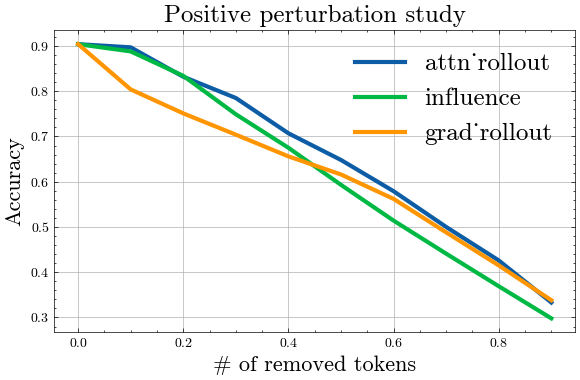

In [13]:
metrics = ['attn_rollout','influence', 'grad_rollout']

plt.figure(figsize=(6,4))
for metric in metrics:
    x = pd.read_pickle(f"data/results/{metric}_perturbation_positive.pkl")
    auc = np.trapz(x.values, x.index)

    print(f"{metric} - AUC = {auc}")
    plt.plot(x, label = metric, linewidth = 3)

plt.grid()
plt.title("Positive perturbation study", fontsize = 18)
plt.ylabel("Accuracy", fontsize = 16)
plt.xlabel("# of removed tokens", fontsize = 16)
plt.legend(fontsize = 18)
plt.tight_layout()